In [1]:
import numpy as np
import brainpy.math as bm
import matplotlib.pyplot as plt
from Network_models import HD_cell, GD_cell, traj, circle_period
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from scipy.signal import find_peaks, peak_widths

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:

bm.set_dt(1.)
num_hd = 100
noise_stre = 0.1
v0 = 1.0*bm.pi/1000 #baseline speed
offset_len = 1/9
Animal_speed = 1.0*v0 #vary this to change the speed of the animal
A = 5. #1.6
mbar_gc = 20. 
mabr_hd = 12.

alpha_hd = 0.4
alpha_gc = 0.6

Grid_net = GD_cell(
    A = A, # 3
    a = 0.8,
    k = 1.0,
    tau = 10.,
    tau_v = 100.,
    mbar = mbar_gc,
    noise_stre = noise_stre,
    num_hd = num_hd,
)
HD_net = HD_cell(num=num_hd, 
                noise_stre = noise_stre/10, #gc has muhc more neurons than hd, 10000 vs 100
                tau=10., tau_v=100., 
                k=1., mbar=mabr_hd, a=0.4, A=3., J0=4., 
                z_min=-bm.pi, z_max=bm.pi)



(2,)


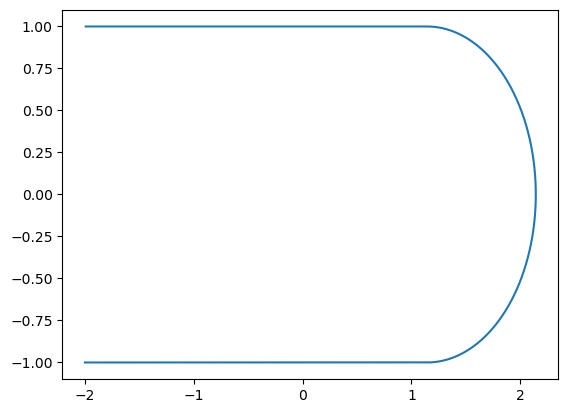

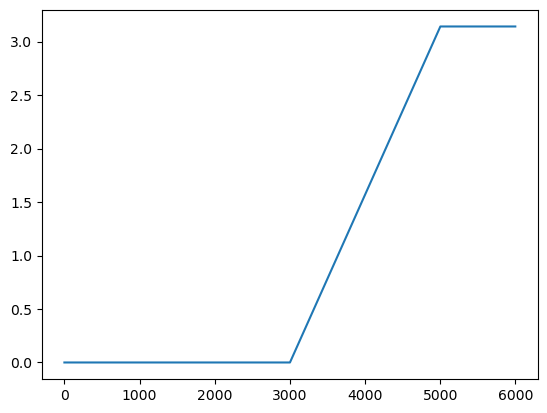

In [3]:
# generate trajecories
x0 = -2
y0 = -1
loc_0 = np.array([x0, y0])
Animal_speed = v0
print(loc_0.shape)
loc = loc_0
start_time = 1500
numT = 1500 + 3000
Animal_location = np.zeros([numT, 2])
Head_direction = np.zeros([numT, 1])
Moving_speed = np.zeros([numT, 1])
hd = 0
for i in range(numT):
    Animal_location[i,:] = loc
    Head_direction[i] = hd
    Moving_speed[i] = Animal_speed
    
    if i > start_time:
        # a_hd = np.where(i>int((start_time+(numT-start_time)/4)), np.pi/((numT-start_time)/2), 0)
        # if i > int(start_time+3*(numT-start_time)/4):
        #     a_hd = 0
        a_hd = 0
        if i>int((start_time+(numT-start_time)/4)):
            a_hd = np.pi/((numT-start_time)/2)
            # hd = np.pi/2
            Animal_speed = v0/2  

        # hd = np.where(i>int((start_time+(numT-start_time)/4)), np.pi/2, 0)
        if i > int(start_time+3*(numT-start_time)/4):
            # hd = np.pi
            a_hd = 0
            Animal_speed = v0
        
        v = np.array([np.cos(hd), np.sin(hd)]) * Animal_speed
        loc = loc + v * bm.dt
        hd += a_hd 
plt.plot(Animal_location[:,0], Animal_location[:,1])
plt.figure()
plt.plot(Head_direction)


In [4]:

# run coupled net
def run_CoupleNet(i, Animal_location, Head_direction, Moving_speed):  # 20 x size

    theta_modulation_stre_hd = alpha_hd * 1/v0 * Moving_speed
    theta_modulation_stre_gc = alpha_gc * 1/v0 * Moving_speed

    T_theta = 100
    #calculate TheataModulator at time step i
    t = i*bm.dt
    theta_phase = bm.mod(t, T_theta)/T_theta # theta phase（0,1）
    ThetaModulator_HD = 1+theta_modulation_stre_hd*bm.cos(theta_phase*2*bm.pi)
    ThetaModulator_GC = 1+theta_modulation_stre_gc*bm.cos(theta_phase*2*bm.pi)
    
    #calculate internal head direction
    HD_net.step_run(i, Head_direction, ThetaModulator_HD)
    Internal_direction = HD_net.center #center of mass of internal direction
    HD_activity = HD_net.r 
    #update the grid cell network 
    Phase_Offset = offset_len
    Grid_net.step_run(i, Animal_location, HD_activity, ThetaModulator_GC, Phase_Offset, Head_direction)
    
    #get results
    GC_bumpcenter = Grid_net.center
    center_grid_input = Grid_net.center_conjG
    GC_bumpactivity = Grid_net.r
    return GC_bumpcenter, Internal_direction, center_grid_input, GC_bumpactivity, HD_activity


# run network

time_steps = np.arange(numT)
center_grid, center_HD, center_grid_input, r_grid, r_HD = bm.for_loop(
    run_CoupleNet, (time_steps, Animal_location, Head_direction, Moving_speed), progress_bar=True
)


  0%|          | 0/6000 [00:00<?, ?it/s]

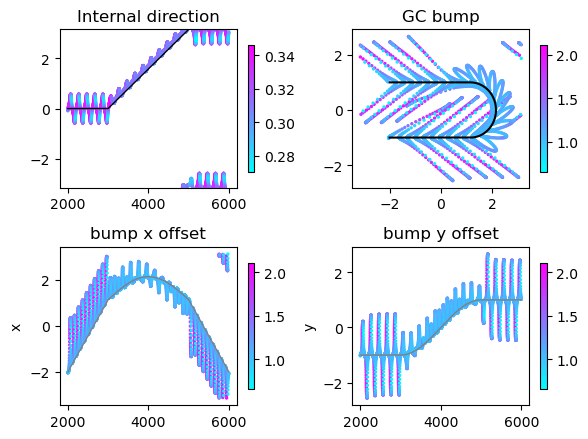

In [5]:
start=start_time
max_r_grid = np.max(r_grid, axis=1)
max_bump_activity = np.max(r_HD, axis=1)
fig, axs = plt.subplots(2, 2, figsize=(6, 4.5))
s_size = 2

ax = axs[0, 0]
ax.plot(time_steps[start:], Head_direction[start:], linewidth=1, color='black')

# cb = ax.scatter(time_steps[10:], 
#                 center_HD[10:], 
#                 c=max_bump_activity[10:], 
#                 cmap='cool', s=s_size)
cb = ax.scatter(time_steps[start:], 
                center_HD[start:], 
                c=max_bump_activity[start:], 
                cmap='cool', s=s_size)
ax.set_ylim(-bm.pi, bm.pi)
#colorbar
cbar = plt.colorbar(cb, ax=ax, shrink=0.8)
ax.set_title('Internal direction')

ax = axs[0, 1]
sc = ax.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.plot(Animal_location[start:, 0], Animal_location[start:, 1], color="black")
ax.set_title('GC bump')


ax = axs[1, 0]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Animal_location[start:, 0], color='grey', linewidth=1)
ax.set_ylabel("x")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 0],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump x offset')


ax = axs[1, 1]
# ax.scatter(range(len(center_grid[start:, 0])), x[start:], s=1, color='grey')
ax.plot(time_steps[start:], Animal_location[start:, 1], color='grey', linewidth=1)
ax.set_ylabel("y")
sc = ax.scatter(
                time_steps[start:],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
ax.set_title('bump y offset')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'GC bump')

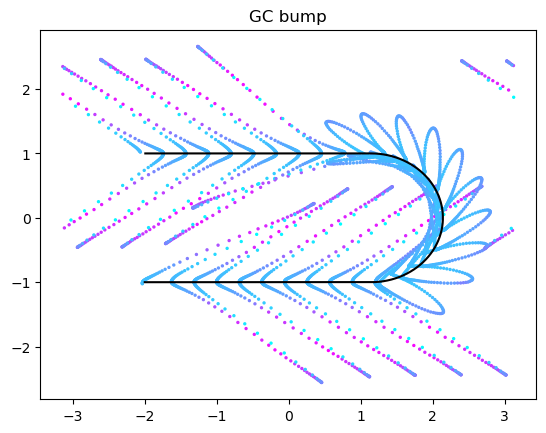

In [7]:
sc = plt.scatter(
                center_grid[start:, 0],
                center_grid[start:, 1],
                c=max_r_grid[start:],
                cmap="cool",
                s=s_size,
)
cbar = plt.colorbar(sc, ax=ax, shrink=0.8)
plt.plot(Animal_location[start:, 0], Animal_location[start:, 1], color="black")
plt.title('GC bump')